In [3]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
def rotation(r):
    return np.asarray([np.cos(r), -np.sin(r), np.sin(r), np.cos(r)]).reshape(2, 2)

# needed by many blocks. Roation matrix might have sign differences from standard

The below is to converty from raw boat measurements to a standard boat outline, with
the 0,0  point at some handy fiducial point, e.g. the back of the mast.

In [11]:
# read in Tech deck data

file = open("./tech_coords_raw.csv")
deck_data_orig = np.loadtxt(file, delimiter=",")
fid_point = np.array([[-939,1]]) # the 'fiducial point', measured in same manner as the raw data. Point is the rear edge of the forward mast support
#print(deck_data_orig)


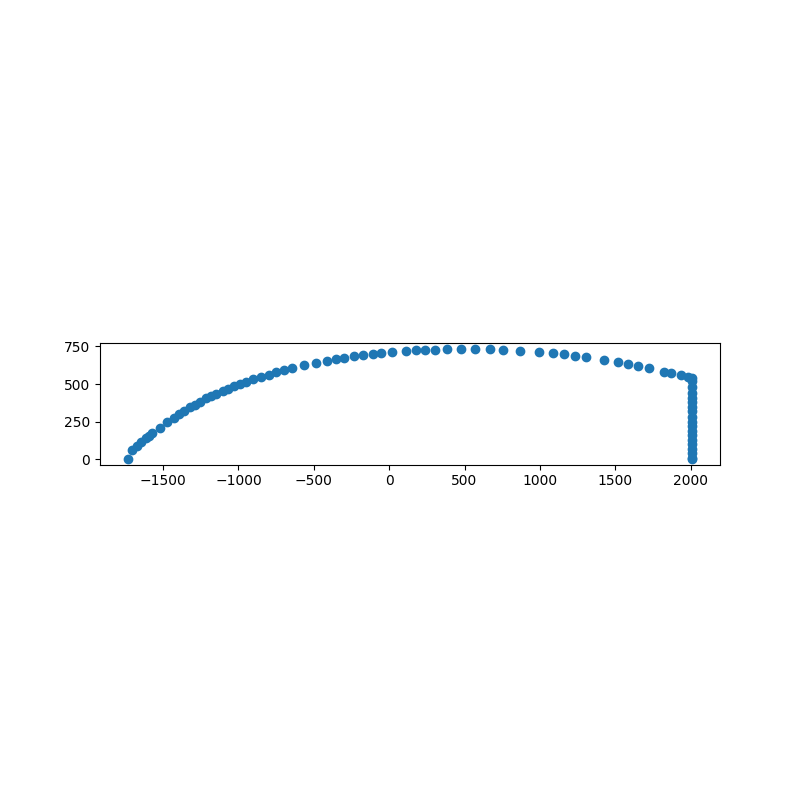

In [12]:
# file is outline of half a boat...
fig, ax = plt.subplots(1, figsize=(8,8))
plt.scatter(deck_data_orig[:,0],deck_data_orig[:,1])
ax.set_aspect('equal')


In [13]:
#deck data has the 'centerline' at y = 1, not 0
np.min(deck_data_orig[:,1])


1.0

In [15]:
# fix deck data. 
# Make center line of boat = 0
deck_data_centered = deck_data_orig - [0,1]

# make 0,0 the fiducial point (the rear edge of the forward mast support)
deck_data_trans = deck_data_centered  - [-939,0] # location of the fid point

# Make boat 3.937 meters long (because that's how long techs are)
scale_factor = 3.937/np.abs(deck_data_trans[0,0] - deck_data_trans[-1,0])
deck_data_final = deck_data_trans * [scale_factor,scale_factor]

#deck_data_final, boat pointing west

# rotate data so boat points north -  this is just swapping the x and y axes
R = rotation(np.pi/2)
tmp_final = np.array(np.matmul(deck_data_final, R))
tmp = tmp_final[:,[1,0]]

#... and mirror about the y axis so we have a whole boat
final = np.vstack((tmp_final, tmp_final*[-1,1]))

# and write out the file

np.savetxt("./tech_coords_final.csv",final, delimiter=',') #translated and scaled to meters




Finished with the transform to the fiducial point

In [16]:
# read in the file
file = open("./tech_coords_final.csv")
outline = np.loadtxt(file, delimiter=",")
file.close()




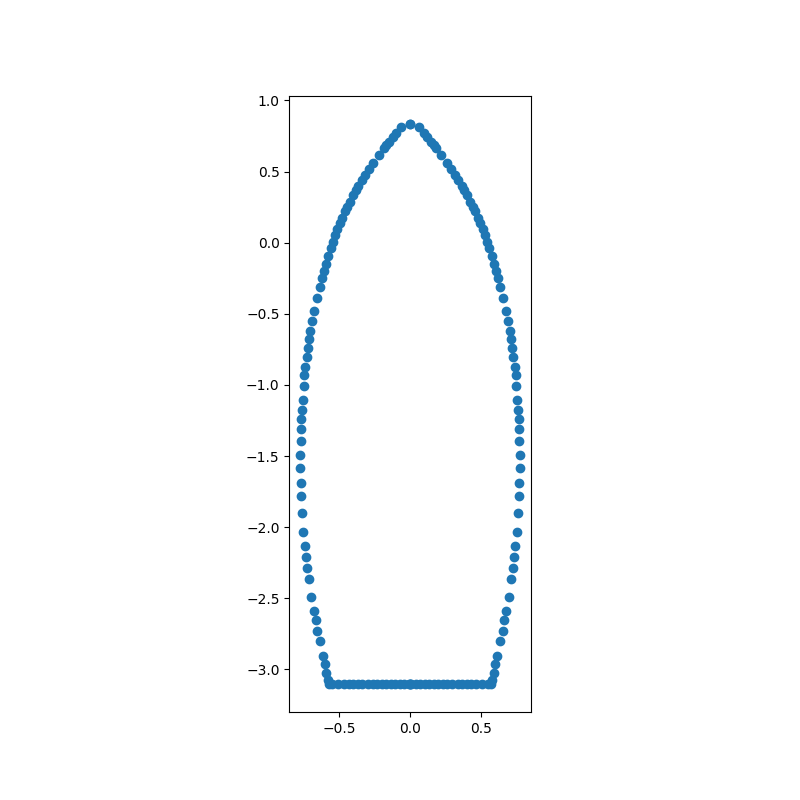

In [17]:
fig, ax = plt.subplots(1, figsize=(8,8))
plt.scatter(outline[:,0],outline[:,1])
ax.set_aspect('equal')

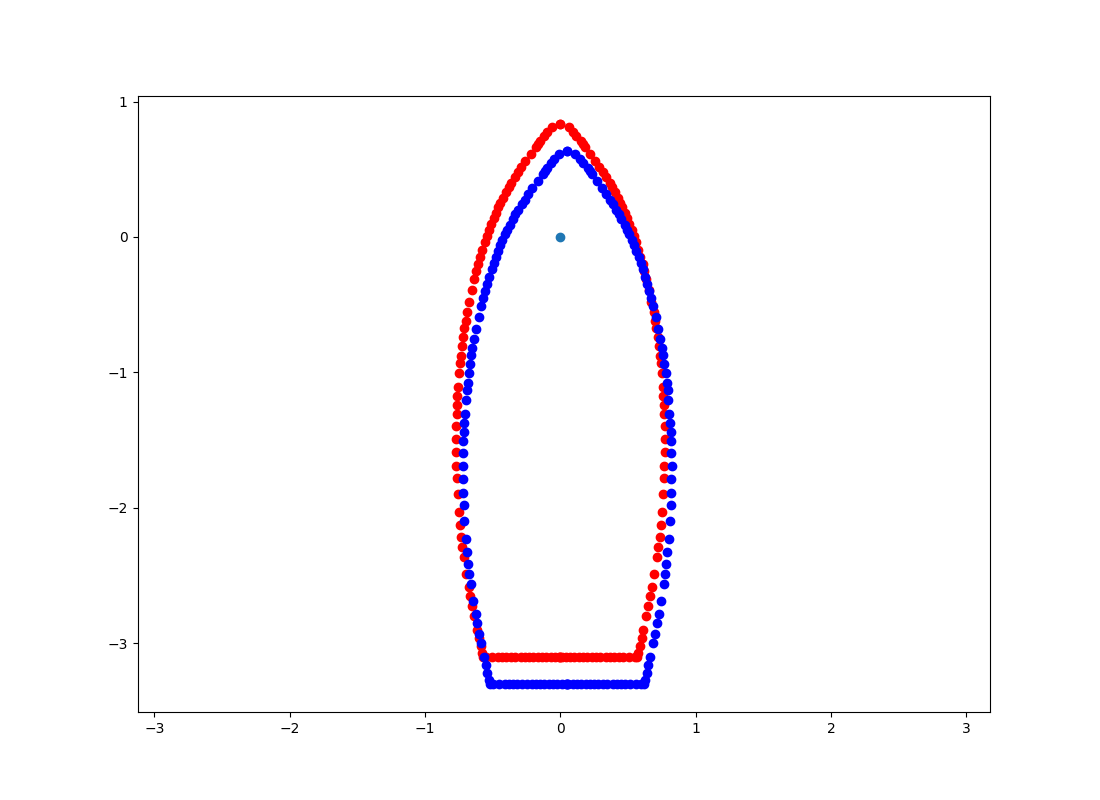

In [18]:
# 4) take into account the position of the device

# The device will be offset by some x,y meters from the fiducial point at 0,0

# let's sat device is .1 m in front of and 0.05 m to port of the mast:
dev_offset = np.array([-0.05, .2])

# move the center of the outline from the fiducial point to the device:

dev_centered = outline - dev_offset

# plot
plt.figure(figsize=(11, 8))
plt.plot(outline[:,0], outline[:,1], 'ro')
plt.plot(dev_centered[:,0], dev_centered[:,1], 'bo')
plt.scatter(0,0)
plt.axis('equal')
plt.show()


In [19]:
# 2) create the rotational transformation

# angles in radians, positive angle means turning boat counterclockwise

# create rotation matrix:
R = rotation(2*np.pi*(61/360)) # angle goes clockwise like compass

# rotate dev_centered:
hull_r = np.matmul(dev_centered, R)
# plot
plt.figure(figsize=(11, 8))
plt.plot(hull_r[:,0], hull_r[:,1], 'bo')
plt.scatter(0,0)
plt.axis('equal')
plt.show()

In [23]:
# 3) find the max distance from the device of the boat to the y-most hull point in the new orientation

# this is just the max value in the positive y direction

print(np.max(hull_r[:,1]))


0.37196950117108896


In [20]:
# line rotation

# set rc and pin so normal start will be to positive y/north
# easting, northing would make positive x east
rc = [0,0]
pin = [-1,0]

line = np.array([rc,pin])
tmp = -np.diff(line, axis=0)


(np.arctan2(tmp[0][0], tmp[0][1]) - np.pi/2) * (360/(2*np.pi))

0.0

So now we have the angle of the line in in angle from north for normal starting line. We also have an angle of the boat, in course_t. 

If the tw are the same, then the (course of the) boat and the line are perpendicular, with the boat crossing the line in the expected direction.

If the angles are different, the boat need to be rotated by the angle (boat angle) - (line angle)

If line angle is zero, the the boat needs to be rotated by the boat angle. 


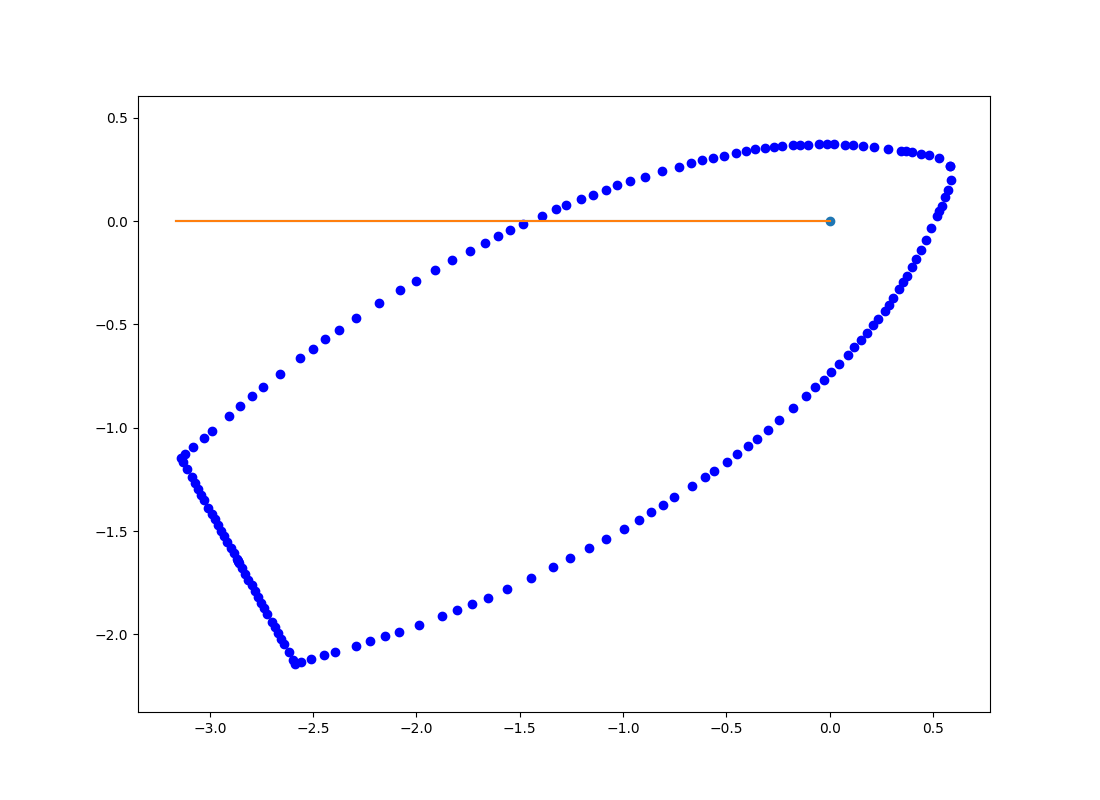

In [22]:
rc=np.array([1,3])
pi=np.array([4,4])

line = np.array([rc, pi])

R = rotation(-np.arctan2([rc[0]-pi[0]],[rc[1]-pi[1]])+np.pi/2)

r_line = np.matmul(line, R)

rc_trans = np.array(r_line[0,:])

rt_line = r_line - rc_trans

plt.plot(rt_line[:,0],rt_line[:,1])
plt.show()

In [23]:
#make some data
cur_data = {}
cur_data['rc'] = [3,4]
cur_data['pi'] = [7,2]
cur_data['12'] = [1,4]
cur_data['2'] = [-1,4]
cur_data['13'] = [9,9]

In [24]:
cur_data.keys()
for i in cur_data.keys():
    print(i)

rc
pi
12
2
13


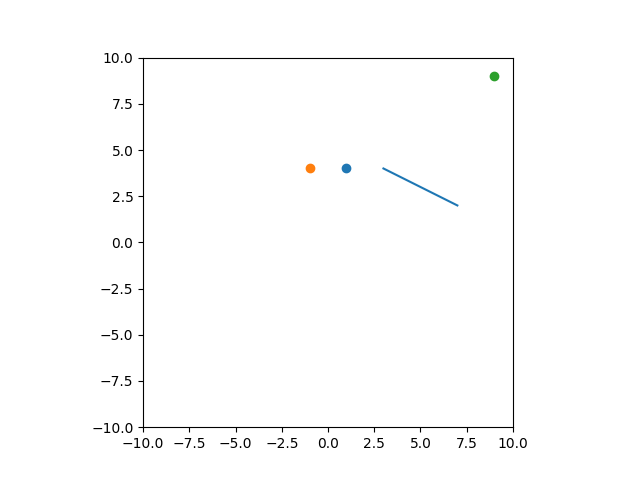

In [25]:
line = np.array([cur_data['rc'],cur_data['pi']])
tmp = -np.diff(line, axis=0)

# compute the rotation matrice
#R = rotation(-np.arctan2(tmp[0][0], tmp[0][1])+np.pi/2)
R = np.identity(2)

# rotate the line
r_line = np.matmul(line,R)

# get the translation vector
#rc_trans = r_line[0,:]
rc_trans = [0,0] 

# translate the line
rt_line = r_line - rc_trans

# set up the plot 
fig, ax = plt.subplots(1)

# clear the axes
ax.clear()
# plot the starting line
plt.plot(rt_line[:,0],rt_line[:,1])

# plot the boats
for i in cur_data.keys():
    if i not in ['rc','pi']:
        tmp = np.array(cur_data[i])
        r_tmp = np.matmul(tmp,R)
        rt_tmp = r_tmp - rc_trans
        plt.scatter(rt_tmp[0], rt_tmp[1] )

plt.xlim([-10,10])
plt.ylim([-10,10])
ax.set_aspect('equal')
plt.show()

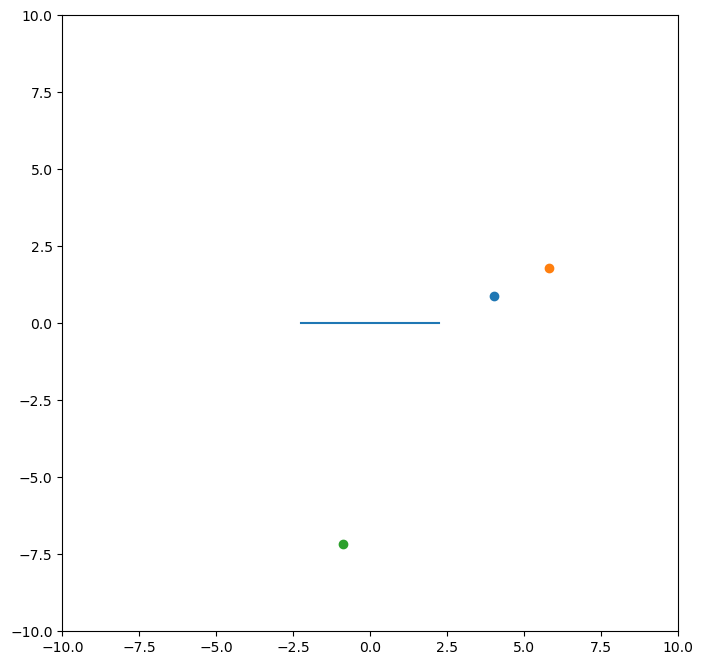

In [29]:
line = np.array([cur_data['rc'],cur_data['pi']])
tmp = -np.diff(line, axis=0)

# compute the rotation matrice
R = rotation(-np.arctan2(tmp[0][0], tmp[0][1])+np.pi/2)
#R = np.identity(2)

# rotate the line
r_line = np.matmul(line,R)

# get the translation vector
rc_trans = np.array(r_line[0,:])
tmp =  rc_trans[0] - (r_line[0,0]-r_line[1,0])/2
rc_trans[0] -= (r_line[0,0]-r_line[1,0])/2
#rc_trans = [0,0] 

# translate the line
rt_line = r_line - rc_trans

# set up the plot 

fig, ax = plt.subplots(1, figsize=(8,8))

# clear the axes
ax.clear()
# plot the starting line
plt.plot(rt_line[:,0],rt_line[:,1])

# plot the boats
for i in cur_data.keys():
    if i not in ['rc','pi']:
        tmp = np.array(cur_data[i])
        r_tmp = np.matmul(tmp,R)
        rt_tmp = r_tmp - rc_trans
        plt.scatter(rt_tmp[0], rt_tmp[1] )

plt.xlim([-10,10])
plt.ylim([-10,10])
ax.set_aspect('equal')
plt.show()

In [26]:
line

array([[3, 4],
       [7, 2]])

In [27]:
(r_line[0,0]-r_line[1,0])/2

-2.0

In [28]:
rc_trans

[0, 0]

In [29]:
tmp =  rc_trans[0] - (r_line[0,0]-r_line[1,0])/2
print(tmp)

2.0


In [30]:
rc_trans

[0, 0]

In [31]:
rc_trans[0] = tmp
print(rc_trans)

[2.0, 0]


In [32]:
r_line - rc_trans


array([[1., 4.],
       [5., 2.]])

And now for some rotation things to make sure we know what we are doing

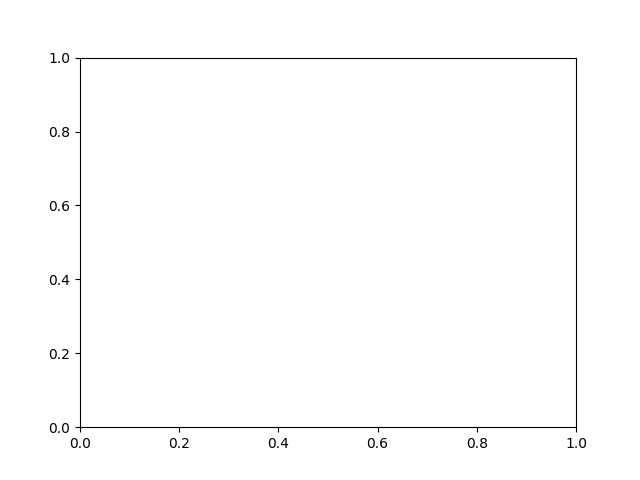

In [33]:
fig, ax = plt.subplots(1)

In [34]:

def rotation(r):
    return np.asarray([np.cos(r), -np.sin(r), np.sin(r), np.cos(r)]).reshape(2, 2)


In [35]:
# enter some data
cur_data = {}
#cur_data['129']= [328056.33427189686, 4691675.372879842]  #real rc
#cur_data['130']= [328042.32806549885, 4691669.4503426915]   # real pin

cur_data['129']= [-10,10]  # fake rc
cur_data['130']= [15,-25]  # fake pin


In [36]:
if ('129' in cur_data.keys() and '130' in cur_data.keys()):
    line =  np.array([cur_data['129'],cur_data['130']])
    d_tmp = np.array(cur_data['129']) - np.array(cur_data['130'])
                   


In [37]:
d_tmp


array([-25,  35])

In [38]:
 # compute the line rotation 
line_angle = (-np.arctan2(d_tmp[0], d_tmp[1]) + np.pi/2)   # clockwise from north
# compute the line rotation matrice
line_R = rotation(line_angle)
#line_R = rotation(2*np.pi*(330/360))
# rotate the line
r_line = np.matmul(line,line_R)

# get the translation vector
rc_trans = np.array(r_line[0,:])
rc_trans[0] -= (r_line[0,0]-r_line[1,0])/2

# translate the line
rt_line = r_line - rc_trans  # the 't' denotes post-translation


In [39]:
line_angle * 360 / (2*np.pi)

125.53767779197439

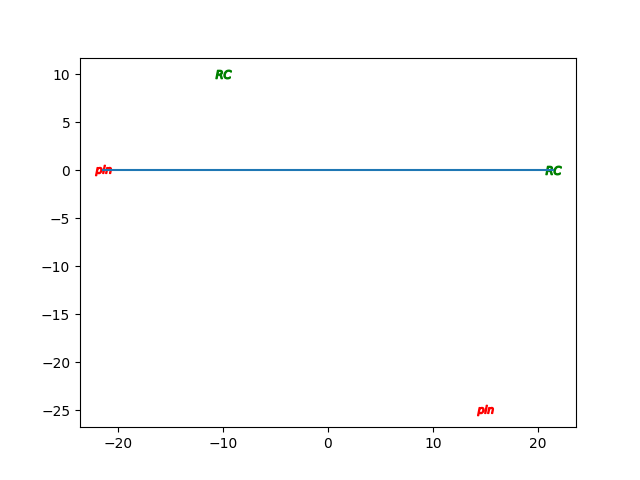

In [40]:
plt.plot(rt_line[:,0],rt_line[:,1])
plt.scatter(rt_line[0,0],rt_line[0,1], s=[128], c =['g'], marker = '$RC$')
plt.scatter(rt_line[1,0],rt_line[1,1], s=[128], c =['r'], marker = '$pin$')
plt.scatter(line[0,0],line[0,1], s=[128], c =['g'], marker = '$RC$')
plt.scatter(line[1,0],line[1,1], s=[128], c =['r'], marker = '$pin$')

plt.show()